# Clasificación de Imágenes con Modelo de Tensorflow (Keras)

Este cuaderno está dedicado a la investigación y entrenamiento de un modelo básico de Tensorflow, usando Keras.

Tanto el modelo como las transformaciones han cambiado respecto al resto de modelos.
La única similitud se mantiene en la carga de datos y la representación de imágenes, que se basan en código de python normal.

## Imports

In [30]:
import os
import tifffile
import shutil
import tempfile
import torch
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm 
import numpy as np
import random
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from typing import Sequence

## Celulas de Entrenamiento y Test

Recoge las células de entrenamiento y de test de cada una de 

In [31]:
root_dir = "/home/jose/TFG/Data/Celulas"

# Directorio que contiene tus datos locales
data_dir_train = os.path.join(root_dir, "entrenamiento")
data_dir_test = os.path.join(root_dir, "test")
# Verifica si el directorio de datos existe
if not os.path.exists(data_dir_train):
    raise FileNotFoundError(f"El directorio de datos de entrenamiento {data_dir_train} no existe.")
if not os.path.exists(data_dir_test):
    raise FileNotFoundError(f"El directorio de datos de prueba {data_dir_test} no existe.")
print(data_dir_train)
print(data_dir_test)

/home/jose/TFG/Data/Celulas/entrenamiento
/home/jose/TFG/Data/Celulas/test


## Semilla determinista

In [32]:
tf.random.set_seed(7)

## Cargar los Datafolders


Total de imágenes: 1743
Dimensiones de las imágenes: 200 x 200
Nombres de las etiquetas: ['altogrado', 'ascus', 'bajogrado', 'benigna']
Número de imágenes por etiqueta: [879, 389, 293, 182]


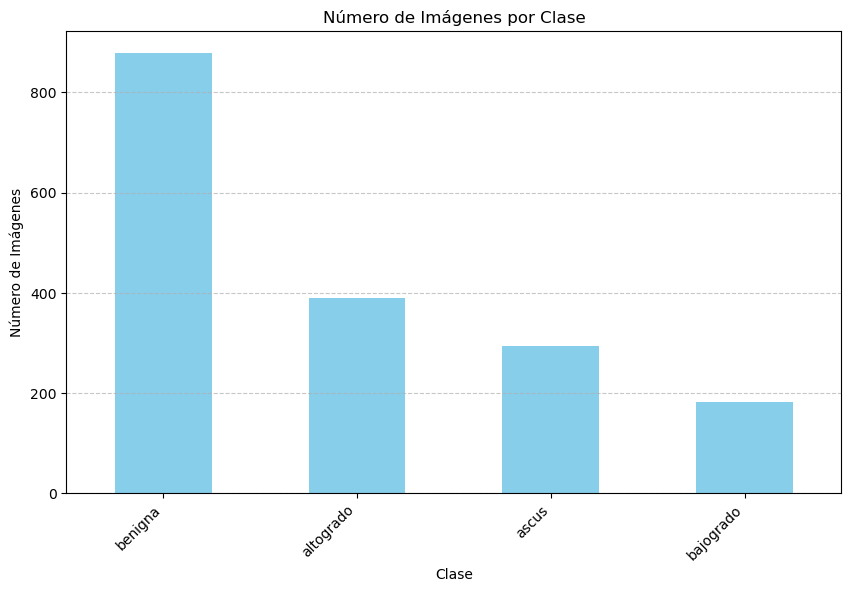

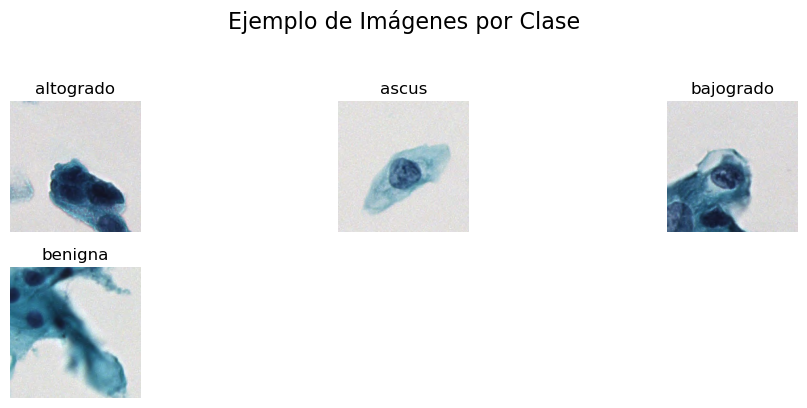

In [33]:
# Obtener los nombres de las clases de entrenamiento
class_names_train = sorted(x for x in os.listdir(data_dir_train) if os.path.isdir(os.path.join(data_dir_train, x)) and x != '.ipynb_checkpoints')
num_class_train = len(class_names_train)

# Obtener la lista de rutas a las imágenes TIFF y las etiquetas de clase correspondientes
image_files_list_train = []
image_class_train = []

for i, class_name_train in enumerate(class_names_train):
    class_dir_train = os.path.join(data_dir_train, class_name_train)
    image_files_train = [os.path.join(class_dir_train, x) for x in os.listdir(class_dir_train) if x.endswith('.tiff') and not x.startswith('.')]  # Filtrar archivos TIFF y ocultos
    image_files_list_train.extend(image_files_train)
    image_class_train.extend([class_name_train] * len(image_files_train))  # Guardar el nombre de la clase en lugar del índice

# Crear un DataFrame con las rutas de las imágenes y las etiquetas de clase
df_train = pd.DataFrame({
    'image_path': image_files_list_train,
    'class_name': image_class_train
})

num_total_train = len(image_class_train)
image_width, image_height = Image.open(image_files_list_train[0]).size

# Mostrar información sobre los datos
print(f"Total de imágenes: {num_total_train}")
print(f"Dimensiones de las imágenes: {image_width} x {image_height}")
print(f"Nombres de las etiquetas: {class_names_train}")
print(f"Número de imágenes por etiqueta: {df_train['class_name'].value_counts().tolist()}")

# Gráfico de barras para mostrar el número de imágenes por etiqueta de clase
plt.figure(figsize=(10, 6))
df_train['class_name'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Número de Imágenes por Clase')
plt.xlabel('Clase')
plt.ylabel('Número de Imágenes')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Mostrar una muestra de una imagen por clase
plt.figure(figsize=(10, 6))
num_classes_display = min(9, len(class_names_train))
for i, class_name in enumerate(class_names_train[:num_classes_display]):
    class_sample = df_train[df_train['class_name'] == class_name].sample(n=1).iloc[0]
    image = Image.open(class_sample['image_path'])
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis('off')
plt.suptitle('Ejemplo de Imágenes por Clase', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Celulas de prueba

Total de imágenes: 120
Dimensiones de las imágenes: 200 x 200
Nombres de las etiquetas: ['altogrado', 'ascus', 'bajogrado', 'benigna']
Número de imágenes por etiqueta: [30, 30, 30, 30]


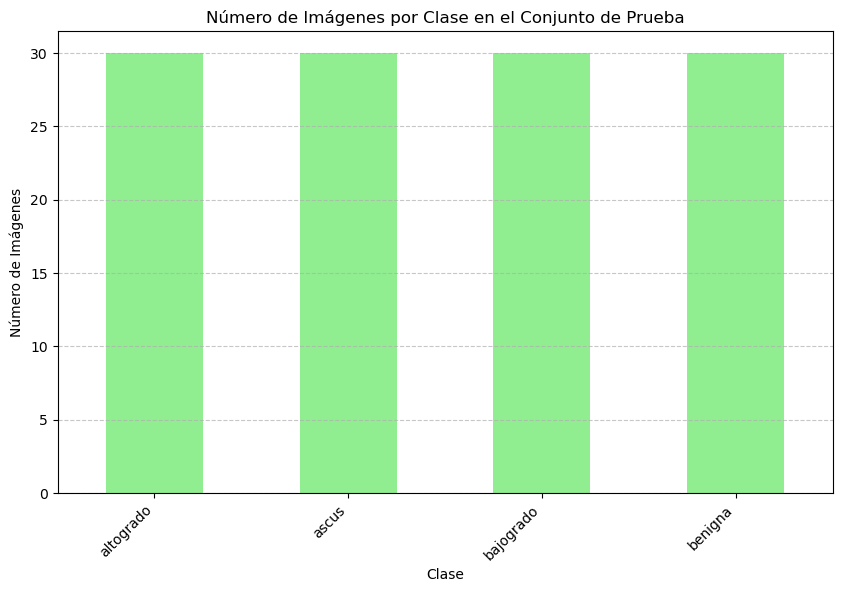

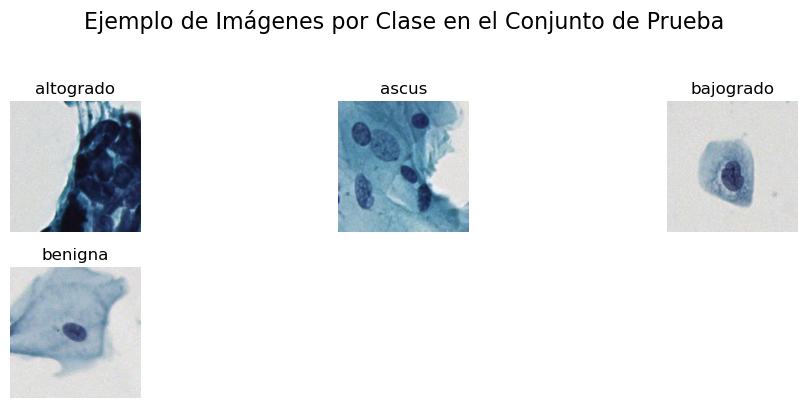

In [34]:
# Obtener nombres de las clases
class_names_test = sorted([x for x in os.listdir(data_dir_test) if os.path.isdir(os.path.join(data_dir_test, x)) and x != '.ipynb_checkpoints'])
num_class_test = len(class_names_test)

# Función para obtener rutas de imágenes y sus etiquetas
def get_image_files_and_labels(class_name):
    class_dir = os.path.join(data_dir_test, class_name)
    image_files = [os.path.join(class_dir, x) for x in os.listdir(class_dir) if x.endswith('.tiff') and not x.startswith('.')]
    return image_files, [class_name] * len(image_files)

# Usar ThreadPoolExecutor para paralelizar la lectura de archivos
image_files_list_test = []
image_class_test = []

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(get_image_files_and_labels, class_name) for class_name in class_names_test]
    for future in futures:
        image_files, labels = future.result()
        image_files_list_test.extend(image_files)
        image_class_test.extend(labels)

num_total_test = len(image_class_test)

# Leer una imagen para obtener las dimensiones
sample_image = PIL.Image.open(image_files_list_test[0])
image_width, image_height = sample_image.size

# Crear un DataFrame para manejar los datos
df_test = pd.DataFrame({
    'image_path': image_files_list_test,
    'class_name': image_class_test
})

# Mostrar información sobre los datos de prueba
print(f"Total de imágenes: {num_total_test}")
print(f"Dimensiones de las imágenes: {image_width} x {image_height}")
print(f"Nombres de las etiquetas: {class_names_test}")
print(f"Número de imágenes por etiqueta: {df_test['class_name'].value_counts().tolist()}")

# Gráfico de barras para mostrar el número de imágenes por etiqueta de clase en el conjunto de prueba
plt.figure(figsize=(10, 6))
df_test['class_name'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Número de Imágenes por Clase en el Conjunto de Prueba')
plt.xlabel('Clase')
plt.ylabel('Número de Imágenes')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Mostrar una muestra de una imagen por clase en el conjunto de prueba
plt.figure(figsize=(10, 6))
num_classes_display = min(9, len(class_names_test))
for i, class_name in enumerate(class_names_test[:num_classes_display]):
    class_sample = df_test[df_test['class_name'] == class_name].sample(n=1).iloc[0]
    image = PIL.Image.open(class_sample['image_path'])
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(class_name)
    plt.axis('off')
plt.suptitle('Ejemplo de Imágenes por Clase en el Conjunto de Prueba', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## IMÁGENES DE ENTRENAMIENTO

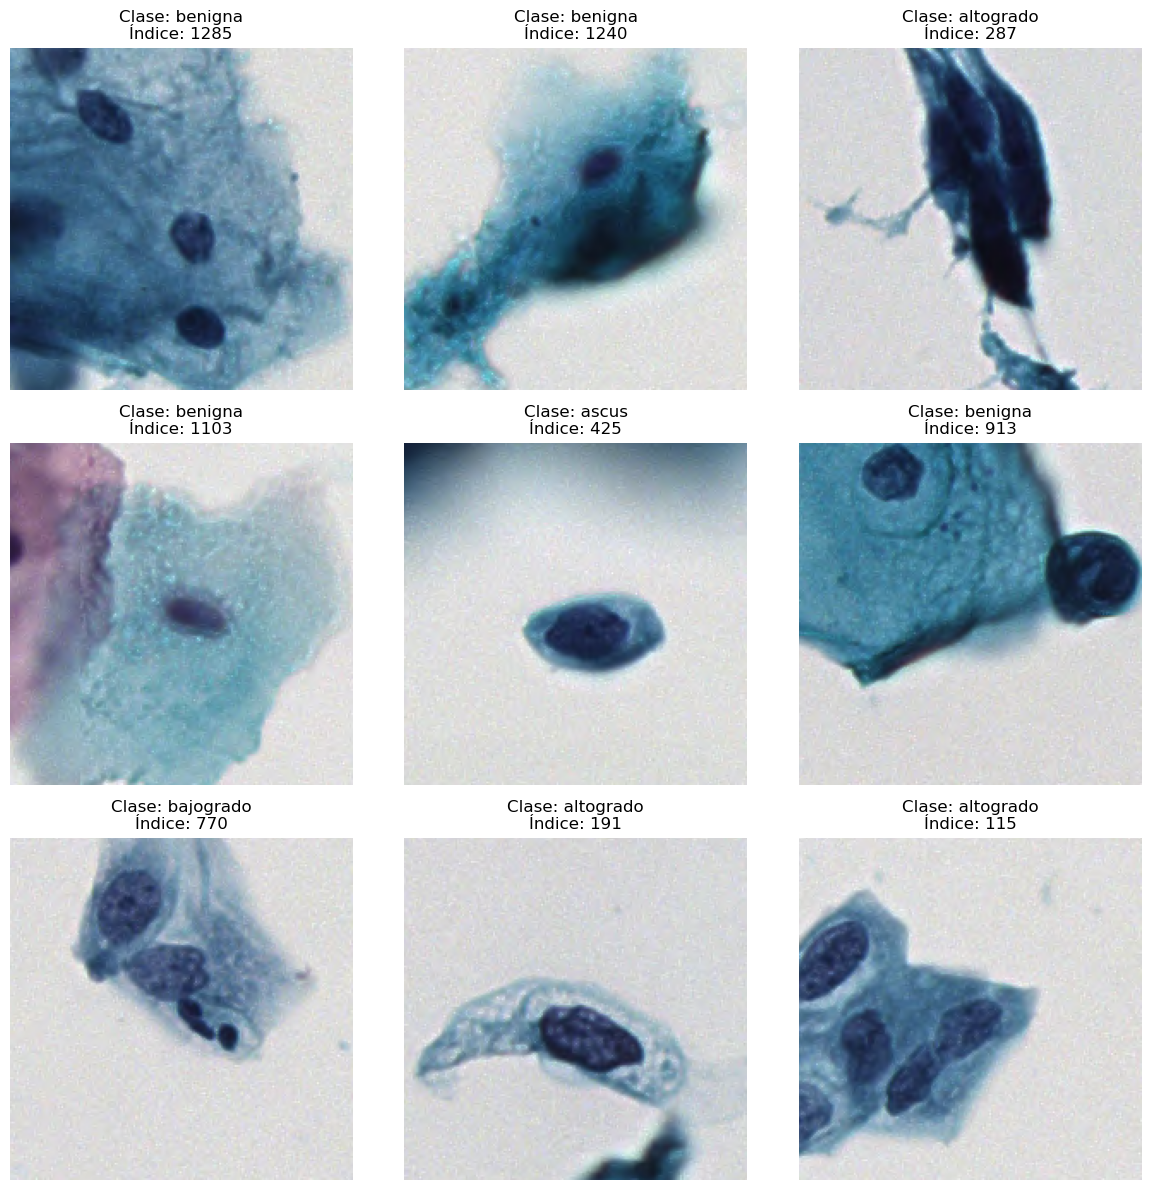

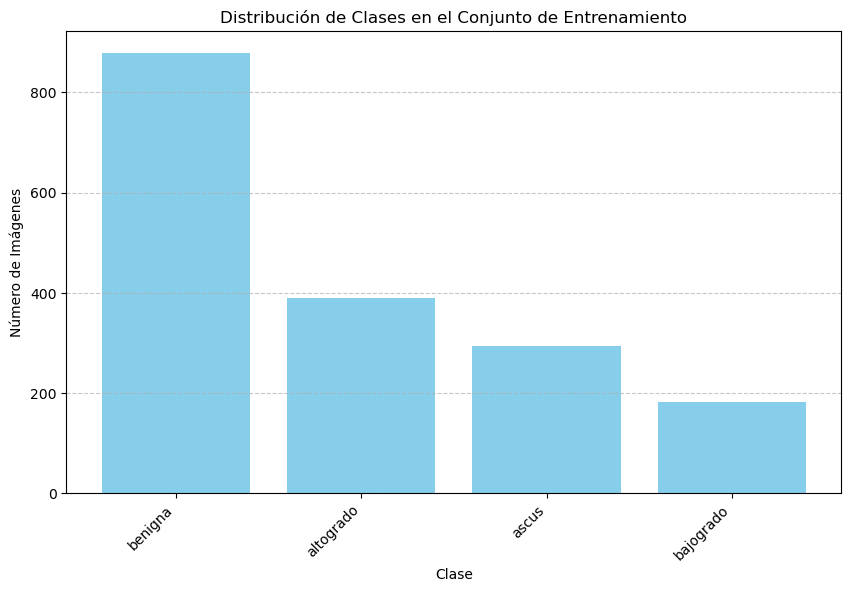

In [35]:
# Crear subgráficos
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Seleccionar aleatoriamente 9 imágenes sin reemplazo
random_indices = np.random.choice(num_total_train, size=9, replace=False)

# Mostrar las imágenes y etiquetas
for i, idx in enumerate(random_indices):
    ax = axs[i // 3, i % 3]
    image_path = image_files_list_train[idx]
    image = PIL.Image.open(image_path)
    ax.imshow(image, cmap="gray", vmin=0, vmax=255)
    class_name = image_class_train[idx]  # Obtener el nombre de la clase directamente
    ax.set_title(f"Clase: {class_name}\nÍndice: {idx}")
    ax.axis("off")

# Ajustar diseño y mostrar
plt.tight_layout()
plt.show()

# Crear un DataFrame para la distribución de clases
class_distribution = df_train['class_name'].value_counts().reset_index()
class_distribution.columns = ['class_name', 'count']

# Mostrar gráfico de barras de la distribución de clases
plt.figure(figsize=(10, 6))
plt.bar(class_distribution['class_name'], class_distribution['count'], color='skyblue')
plt.title('Distribución de Clases en el Conjunto de Entrenamiento')
plt.xlabel('Clase')
plt.ylabel('Número de Imágenes')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## IMAGENES DE PRUEBA

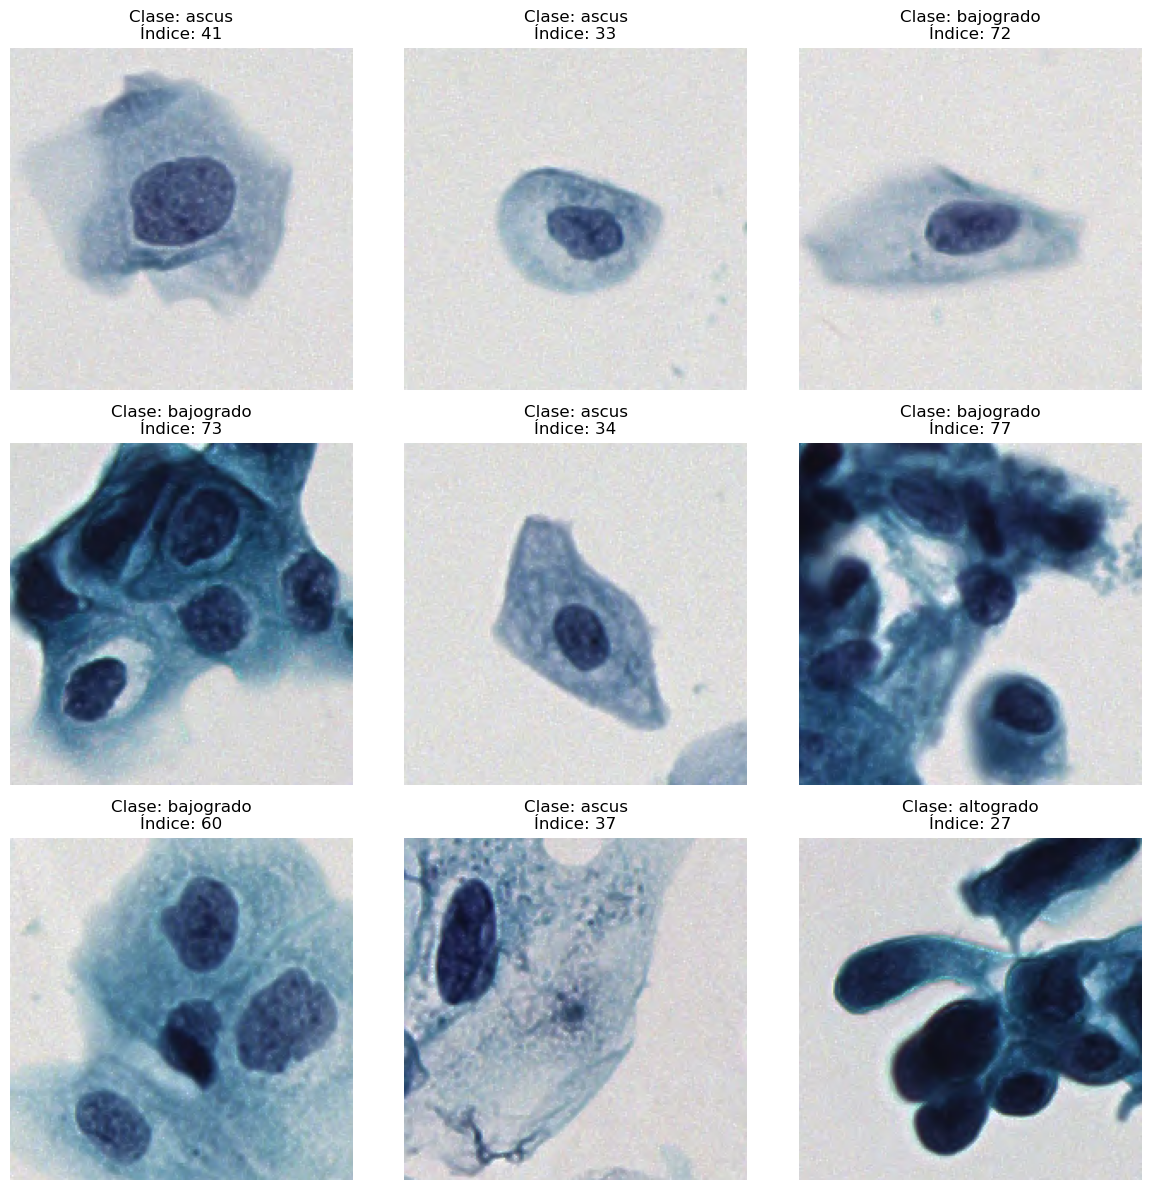

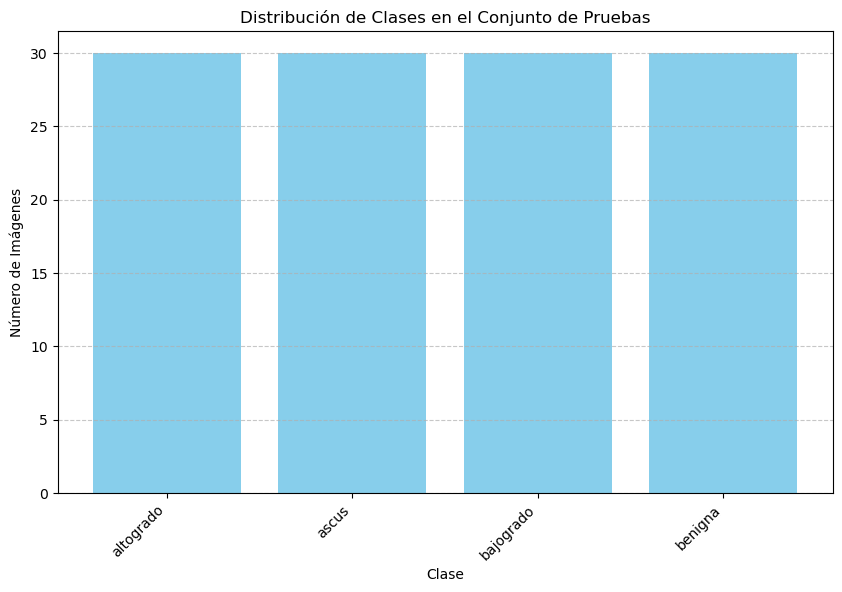

In [36]:
# Crear subgráficos
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Seleccionar aleatoriamente 9 imágenes sin reemplazo
random_indices = np.random.choice(num_total_test, size=9, replace=False)

# Mostrar las imágenes y etiquetas
for i, idx in enumerate(random_indices):
    ax = axs[i // 3, i % 3]
    image_path = image_files_list_test[idx]
    image = PIL.Image.open(image_path)
    ax.imshow(image, cmap="gray", vmin=0, vmax=255)
    class_name = image_class_test[idx]  # Obtener el nombre de la clase directamente
    ax.set_title(f"Clase: {class_name}\nÍndice: {idx}")
    ax.axis("off")

# Ajustar diseño y mostrar
plt.tight_layout()
plt.show()

# Crear un DataFrame para la distribución de clases
class_distribution_test = pd.DataFrame({
    'class_name': class_names_test,
    'count': [image_class_test.count(class_name) for class_name in class_names_test]
})

# Mostrar gráfico de barras de la distribución de clases
plt.figure(figsize=(10, 6))
plt.bar(class_distribution_test['class_name'], class_distribution_test['count'], color='skyblue')
plt.title('Distribución de Clases en el Conjunto de Pruebas')
plt.xlabel('Clase')
plt.ylabel('Número de Imágenes')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Preparar conjunto de datos de entrenamiento, validación y test

Se elige de manera aleatoria un 10% de los datos de entrenamiento para la validación.

In [37]:
val_frac = 0.1
length_train = len(image_files_list_train)
length_test = len(image_files_list_test)
indices_train = np.arange(length_train)
indices_test = np.arange(length_test)
np.random.shuffle(indices_train)
np.random.shuffle(indices_test)
test_split = int(length_test)
val_split = int(val_frac * length_train) + test_split
test_indices = indices_test[:test_split]
val_indices = indices_train[test_split:val_split]
train_indices = indices_train[val_split:]

train_x = [image_files_list_train[i] for i in train_indices]
train_y = [image_class_train[i] for i in train_indices]
val_x = [image_files_list_train[i] for i in val_indices]
val_y = [image_class_train[i] for i in val_indices]
test_x = [image_files_list_test[i] for i in test_indices]
test_y = [image_class_test[i] for i in test_indices]

print(f"Training count: {len(train_x)}, Validation count: " f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 1449, Validation count: 174, Test count: 120


## Definición de las Transformaciones y Balanceo de Clases

In [85]:
# Crear un diccionario para mapear las etiquetas a enteros
label_to_int = {label: idx for idx, label in enumerate(class_names_train)}

# Definir transformaciones en TensorFlow
def random_transform(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.rot90(image, k=random.randint(0, 3))  # Rotación aleatoria
    return image

def preprocess_image(image):
    # Convertir a float y normalizar si es necesario
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image

# Función para cargar y preprocesar imágenes TIFF usando tensorflow-io
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tfio.experimental.image.decode_tiff(image)  # Decodificar la imagen TIFF
    image = tf.image.resize(image, [256, 256])  # Redimensionar si es necesario
    if image.shape[-1] == 4:  # Si tiene 4 canales, convertir a 3 canales
        image = image[..., :3]
    image = image / 255.0  # Normalizar la imagen
    return image

def load_and_preprocess_image_tensor(path):
    image = tf.numpy_function(load_and_preprocess_image, [path], tf.float32)
    image.set_shape((256, 256, 3))  # Asegurarse de que todas las imágenes tienen 3 canales
    return image

# Número de imágenes aleatorias que deseas generar por cada imagen original
num_random_images = 40

# Definir una nueva clase de conjunto de datos que aplica transformaciones aleatorias a cada imagen
class RandomTransformDataset(tf.data.Dataset):
    def _generator(image_files, labels, num_random_images):
        for i in range(len(image_files)):
            filename = image_files[i]
            label = labels[i]
            original_image = load_and_preprocess_image_tensor(filename)
            original_image = preprocess_image(original_image)

            # Yield la imagen original y la etiqueta
            yield original_image.numpy(), label_to_int[label.decode('utf-8')]

            # Yield imágenes transformadas aleatoriamente
            for _ in range(num_random_images):
                random_image = random_transform(original_image)
                yield random_image.numpy(), label_to_int[label.decode('utf-8')]

    def __new__(cls, image_files, labels, num_random_images):
        return tf.data.Dataset.from_generator(
            cls._generator,
            args=(image_files, labels, num_random_images),
            output_signature=(
                tf.TensorSpec(shape=(256, 256, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int64)
            )
        )

## Cargar datos de Entrenamiento, Validación y Prueba

In [86]:
# Crear los datasets usando la clase RandomTransformDataset
train_ds = RandomTransformDataset(train_x, train_y, num_random_images)
val_ds = RandomTransformDataset(val_x, val_y, 0)  
test_ds = RandomTransformDataset(test_x, test_y, 0)  

# Configurar los datasets
train_ds = train_ds.shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(64).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(64).prefetch(tf.data.AUTOTUNE)

# Mostrar información sobre los datos
print(f"Total de imágenes de entrenamiento: {len(train_x)}")
print(f"Total de imágenes de validación: {len(val_x)}")
print(f"Total de imágenes de prueba: {len(test_x)}")

Total de imágenes de entrenamiento: 1449
Total de imágenes de validación: 174
Total de imágenes de prueba: 120


## Entrenamiento del Modelo

### Importación de funciones auxiliares de métricas

In [87]:
# Función para calcular métricas de evaluación
def compute_metric(predictions, targets):
    pred_classes = tf.argmax(predictions, axis=1, output_type=tf.int32)
    correct = tf.reduce_sum(tf.cast(pred_classes == targets, tf.float32)).numpy()
    total = len(targets)
    accuracy = correct / total
    
    tp = tf.reduce_sum(tf.cast((pred_classes == 1) & (targets == 1), tf.float32)).numpy()
    tn = tf.reduce_sum(tf.cast((pred_classes == 0) & (targets == 0), tf.float32)).numpy()
    fp = tf.reduce_sum(tf.cast((pred_classes == 1) & (targets == 0), tf.float32)).numpy()
    fn = tf.reduce_sum(tf.cast((pred_classes == 0) & (targets == 1), tf.float32)).numpy()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "specificity": specificity
    }

def compute_composite_metric(metrics):
    accuracy = metrics["accuracy"]
    precision = metrics["precision"]
    recall = metrics["recall"]
    specificity = metrics["specificity"]
    composite_metric = (0.4 * accuracy) + (0.2 * precision) + (0.2 * recall) + (0.2 * specificity)
    return composite_metric

### Definición del Modelo

In [88]:
class ModeloTensorFlow(tf.keras.Model):
    def __init__(self, num_classes):
        super(ModeloTensorFlow, self).__init__()
        # Capas convolucionales con batch normalization
        self.conv1 = layers.Conv2D(64, kernel_size=3, padding='same', activation=None)
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(128, kernel_size=3, padding='same', activation=None)
        self.bn2 = layers.BatchNormalization()
        self.conv3 = layers.Conv2D(256, kernel_size=3, padding='same', activation=None)
        self.bn3 = layers.BatchNormalization()
        self.conv4 = layers.Conv2D(512, kernel_size=3, padding='same', activation=None)
        self.bn4 = layers.BatchNormalization()
        self.conv5 = layers.Conv2D(512, kernel_size=3, padding='same', activation=None)
        self.bn5 = layers.BatchNormalization()
        
        self.pool = layers.MaxPooling2D(pool_size=(2, 2))
        
        # Calcular el tamaño de entrada para las capas completamente conectadas
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(1024, activation='relu')
        self.fc2 = layers.Dense(512, activation='relu')
        self.fc3 = layers.Dense(num_classes, activation='softmax')
        
        # Dropout para regularización
        self.dropout = layers.Dropout(0.5)

    def call(self, x, training=False):
        x = self.pool(tf.nn.relu(self.bn1(self.conv1(x), training=training)))
        x = self.pool(tf.nn.relu(self.bn2(self.conv2(x), training=training)))
        x = self.pool(tf.nn.relu(self.bn3(self.conv3(x), training=training)))
        x = self.pool(tf.nn.relu(self.bn4(self.conv4(x), training=training)))
        x = self.pool(tf.nn.relu(self.bn5(self.conv5(x), training=training)))
        
        x = self.flatten(x)
        x = tf.nn.relu(self.fc1(x))
        x = self.dropout(x, training=training)
        x = tf.nn.relu(self.fc2(x))
        x = self.dropout(x, training=training)
        x = self.fc3(x)
        return x

### Configuración del Entrenamiento

In [89]:
# Configuración del dispositivo
device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"

# Instanciación del modelo
num_classes = 4
model = ModeloTensorFlow(num_classes=num_classes)
model.build(input_shape=(None, 256, 256, 3))

# Definición del optimizador y función de pérdida
optimizer = Adam(learning_rate=1e-4)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])
# Parámetros de entrenamiento
val_interval = 1
max_epochs = 10
patience = 3
best_metric = 0
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
early_stopping_counter = 0


/home/jose/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'modelo_tensor_flow_7', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


### Ciclo de Entrenamiento

In [90]:
# Determinar el directorio de las métricas

metric_dir = "/home/jose/TFG/Metricas"

# Métricas para guardar más adelante
epoch_loss_values = []
metric_values = []
accuracy_values = []
precision_values = []
recall_values = []
specificity_values = []
early_stopping_counter = 0

# Obtener el tamaño de los conjuntos de datos
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
val_ds_size = tf.data.experimental.cardinality(val_ds).numpy()

# Bucle de entrenamiento
for epoch in range(max_epochs):
    model.trainable = True
    epoch_loss = 0
    with tqdm(total=train_ds_size, desc=f'Epoch {epoch + 1}/{max_epochs}', unit='batch') as pbar:
        for step, (inputs, labels) in enumerate(train_ds):
            with tf.GradientTape() as tape:
                outputs = model(inputs, training=True)
                loss = loss_function(labels, outputs)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            epoch_loss += loss.numpy()
            pbar.set_postfix({'loss': loss.numpy()})
            pbar.update(1)
    epoch_loss /= train_ds_size
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.trainable = False
        y_pred = []
        y_true = []
        for val_images, val_labels in val_ds:
            outputs = model(val_images, training=False)
            y_pred.append(outputs)
            y_true.append(val_labels.numpy())
        
        y_pred = tf.concat(y_pred, axis=0)
        y_true = tf.concat(y_true, axis=0)
        metrics = compute_metric(y_pred, y_true)
        composite_metric = compute_composite_metric(metrics)

        accuracy_values.append(metrics["accuracy"])
        precision_values.append(metrics["precision"])
        recall_values.append(metrics["recall"])
        specificity_values.append(metrics["specificity"])
        metric_values.append(composite_metric)
        
        if composite_metric >= best_metric:
            early_stopping_counter = 0
            best_metric = composite_metric
            best_metric_epoch = epoch + 1
            model.save_weights(os.path.join(metric_dir, "Modelos/mejor_modelo_tensorflow.weights.h5"))
            print("Guardado nuevo mejor modelo de métrica compuesta")
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Detención temprana en la época {epoch + 1} ya que la métrica de validación no ha mejorado durante {patience} épocas.")
                break
        print(
            f"Época actual: {epoch + 1} Métricas: {metrics}"
            f" Mejor métrica compuesta: {best_metric:.4f}"
            f" en la época: {best_metric_epoch}"
        )

print(f"Entrenamiento completado, mejor métrica compuesta: {best_metric:.4f} en la época: {best_metric_epoch}")


Epoch 1/10: 1batch [00:16, 16.98s/batch, loss=2.68]


KeyboardInterrupt: 

### Visualización de Resultados

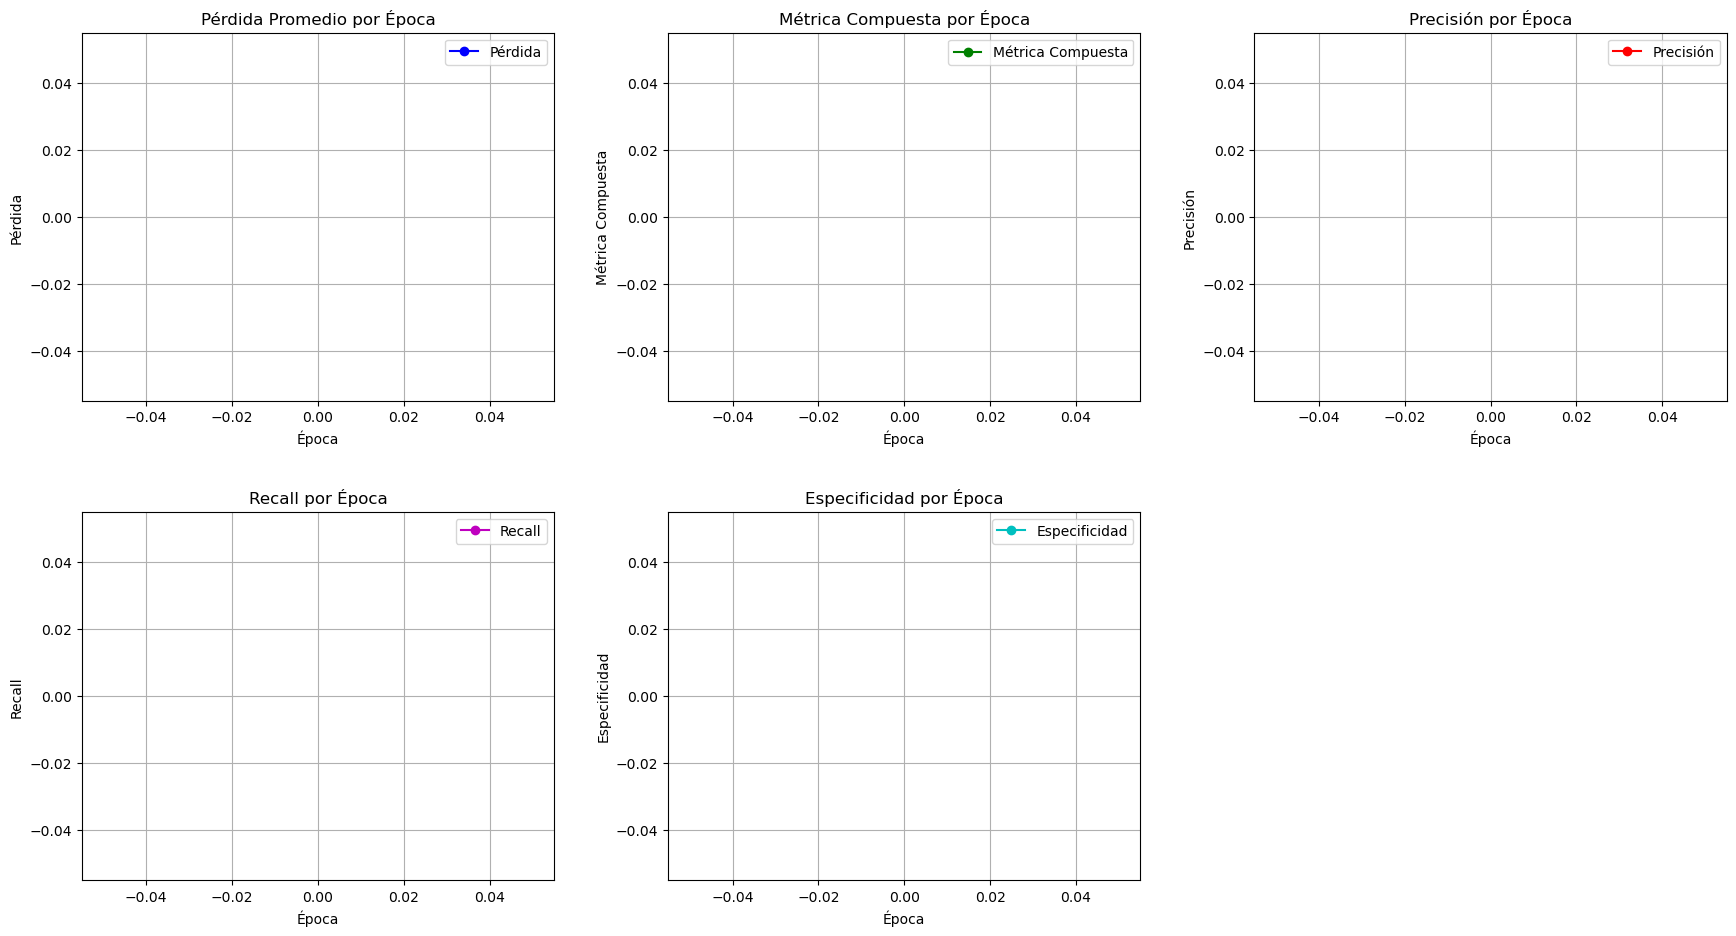

In [82]:
# Visualización de resultados
plt.figure(figsize=(18, 10))

# Gráfico de la pérdida promedio por época
plt.subplot(2, 3, 1)
plt.plot(range(1, len(epoch_loss_values) + 1), epoch_loss_values, marker='o', linestyle='-', color='b', label='Pérdida')
plt.title("Pérdida Promedio por Época")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.grid(True)
plt.legend()

# Gráfico de la métrica compuesta por época
plt.subplot(2, 3, 2)
plt.plot(range(1, len(metric_values) + 1), metric_values, marker='o', linestyle='-', color='g', label='Métrica Compuesta')
plt.title("Métrica Compuesta por Época")
plt.xlabel("Época")
plt.ylabel("Métrica Compuesta")
plt.grid(True)
plt.legend()

# Gráfico de la precisión por época
plt.subplot(2, 3, 3)
plt.plot(range(1, len(precision_values) + 1), precision_values, marker='o', linestyle='-', color='r', label='Precisión')
plt.title("Precisión por Época")
plt.xlabel("Época")
plt.ylabel("Precisión")
plt.grid(True)
plt.legend()

# Gráfico del recall por época
plt.subplot(2, 3, 4)
plt.plot(range(1, len(recall_values) + 1), recall_values, marker='o', linestyle='-', color='m', label='Recall')
plt.title("Recall por Época")
plt.xlabel("Época")
plt.ylabel("Recall")
plt.grid(True)
plt.legend()

# Gráfico de la especificidad por época
plt.subplot(2, 3, 5)
plt.plot(range(1, len(specificity_values) + 1), specificity_values, marker='o', linestyle='-', color='c', label='Especificidad')
plt.title("Especificidad por Época")
plt.xlabel("Época")
plt.ylabel("Especificidad")
plt.grid(True)
plt.legend()

plt.tight_layout(pad=3.0)
plt.show()


## Evaluar el modelo con los datos de prueba

2024-05-20 10:23:45.725528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Total number of samples in the test dataset: 2
Total number of samples evaluated: 120
Accuracy: 0.2500
Precision: 0.0625
Recall: 0.2500
F1 Score: 0.1000


2024-05-20 10:23:50.501916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/jose/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


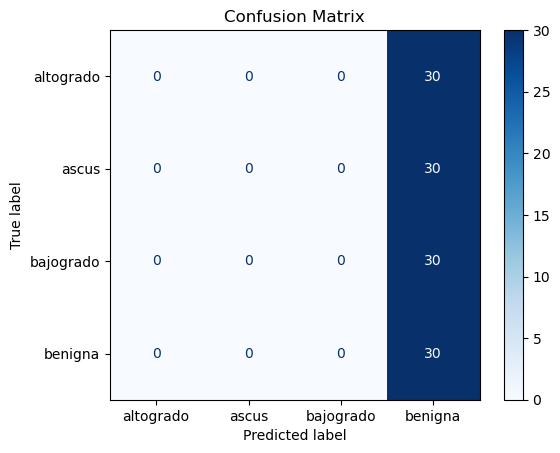

              precision    recall  f1-score   support

   altogrado     1.0000    0.0000    0.0000        30
       ascus     1.0000    0.0000    0.0000        30
   bajogrado     1.0000    0.0000    0.0000        30
     benigna     0.2500    1.0000    0.4000        30

    accuracy                         0.2500       120
   macro avg     0.8125    0.2500    0.1000       120
weighted avg     0.8125    0.2500    0.1000       120



In [84]:
# Cargar el mejor modelo
model.load_weights(os.path.join(metric_dir, "mejor_modelo_tensorflow.weights.h5"))

y_true = []
y_pred = []

# Mostrar el número total de muestras en el conjunto de datos de prueba
test_dataset_size = sum(1 for _ in test_ds)
print(f"Total number of samples in the test dataset: {test_dataset_size}")

# Evaluar el modelo en el conjunto de prueba
for test_images, test_labels in test_ds:
    # Realizar predicciones
    outputs = model(test_images, training=False)
    pred = tf.argmax(outputs, axis=1, output_type=tf.int32)
    
    # Almacenar etiquetas verdaderas y predichas
    y_true.extend(test_labels.numpy())
    y_pred.extend(pred.numpy().astype(int))

# Mostrar el número total de muestras evaluadas
print(f"Total number of samples evaluated: {len(y_true)}")

# Calcular y mostrar métricas de rendimiento
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Mostrar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names_train)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Mostrar el informe de clasificación
print(classification_report(y_true, y_pred, target_names=class_names_train, digits=4, zero_division=1))
